In [2]:
using Graphs, GraphPlot, LinearAlgebra, Colors
using Plots
# using SparseArrays

┌ Info: Precompiling GraphPlot [a2cc645c-3eea-5389-862e-a155d0052231]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [3]:
mutable struct HopfieldNet
    network::SimpleDiGraph
    weights::Matrix
    activations::Vector
    
    function HopfieldNet(network, weights, activations)
        num_nodes = length(vertices(network))
        num_edges = length(edges(network))
        m, n = size(weights)
        if (num_nodes != length(activations)) || (num_nodes != m) || (num_nodes != n)
            error("Mismatch number of neurons with activations or weights")
        end
        new(network, weights, activations)
    end
end

HopfieldNet(n::Integer, p::Real) = HopfieldNet(
    erdos_renyi(n, p, is_directed=true), 
    randn(n, n), 
    rand([-1, 1], n)
)

HopfieldNet(n::Integer, k::Integer, β::Real) = HopfieldNet(
    watts_strogatz(n, k, β, is_directed=true),
    randn(n, n),
    rand([-1, 1], n)
)


function HopfieldNet(w::Matrix, a::Vector) 
    num_nodes = size(w, 1)
    g = SimpleDiGraph(num_nodes)
    for i in 1:num_nodes
        for j in 1:num_nodes
            if abs(w[i, j]) > 1e-5
                add_edge!(g, i, j)
            end
        end
    end
    HopfieldNet(g, w, a)
end

mygplot(g::SimpleDiGraph) = gplot(
    g, 
    layout=circular_layout, 
    nodelabel=vertices(g), 
)

mygplot(g::SimpleDiGraph, w::Matrix) = gplot(
    g, 
    layout=circular_layout, 
    nodelabel=vertices(g), 
    edgelabel=[w[e.src, e.dst] for e in edges(g)]
)

function mygplot(net::HopfieldNet) 
    g = net.network
    w = net.weights
    
    nodefillc = [a >= 0 ? RGBA(1, 0, 0, 0.5) : RGBA(0, 0, 1, 0.5) for a in net.activations]
    gplot(
        g, 
        layout=shell_layout, 
        linetype="curve",
        nodelabel=vertices(g), 
        edgelabel=[round(w[e.src, e.dst], digits=2) for e in edges(g)],
        nodefillc=nodefillc, 
        arrowlengthfrac=0.02,
    )
end

function step!(hopfield_net::HopfieldNet)
    g = hopfield_net.network
    w = hopfield_net.weights
    a = hopfield_net.activations
    a_new = zeros(size(a))
    for neuron in vertices(g)
        weighted_sum = sum(
                [w[neuron, neighbour_neuron] * a[neighbour_neuron] 
                    for neighbour_neuron in inneighbors(g, neuron)]
                )
        a_new[neuron] = weighted_sum >= 0 ? 1 : -1
    end
    hopfield_net.activations = a_new
    hopfield_net
end

function stochastic_step!(hopfield_net::HopfieldNet, rate::Real = 0.5)
    g = hopfield_net.network
    w = hopfield_net.weights
    a = hopfield_net.activations
    a_new = zeros(size(a))
    for neuron in vertices(g)
        if rand() <= rate
            weighted_sum = sign(sum(
                    [w[neuron, neighbour_neuron] * a[neighbour_neuron] # * (rand() > 0.5 ? 1 : 0) # connection dilution
                        for neighbour_neuron in inneighbors(g, neuron)]
                    ))
            a_new[neuron] = weighted_sum >= 0 ? 1 : -1
        end
    end
    hopfield_net.activations = a_new
    hopfield_net
end



stochastic_step! (generic function with 2 methods)

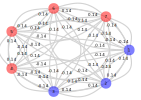

Stabilised at iteration 4
[-1, -1, -1, 1, 1, -1, -1]
[-1, -1, -1, 1, 1, 1, 1]
[-1, -1, -1, 1, 1, 1, 1]


In [4]:
# net = HopfieldNet(20, 5, 0.3)

pattern = [-1, -1, -1, 1, 1, 1, 1]
num_nodes = length(pattern)
w = [a * b for a in pattern, b in pattern] / num_nodes
for i in 1:size(w, 1)
    w[i, i] = 0
end
# # w = diagm(ones(num_nodes))
# w = rand(num_nodes, num_nodes)
# w = w .* (w .>= 0.5)
a = [-1, -1, -1, 1, 1, -1, -1]
net = HopfieldNet(w, a)

a_init = copy(net.activations)
a_current = copy(net.activations)
stabilised = false
count = 0
while !stabilised && count < 100
    IJulia.clear_output(true)
    mygplot(net) |> IJulia.display
    sleep(0.08)
    stochastic_step!(net, 0.9)
#     step!(net)
    if net.activations == a_current
        println("Stabilised at iteration ", count)
        stabilised = true
    end
    a_current = copy(net.activations)
    count += 1
end

println(a_init)
println((net.activations .>= 0) .*2 .- 1)
println(pattern)

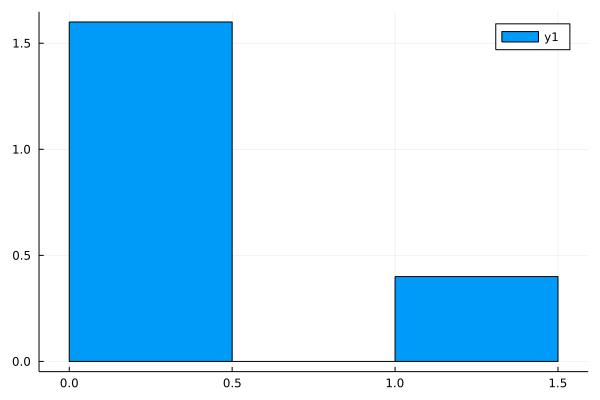

In [178]:
histogram(collect(Iterators.flatten(net.weights)), normalize=true)

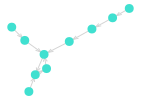

In [148]:
g = watts_strogatz(10, 3, 0.5, is_directed=true)
gplot(g)